In [20]:
# Import Packages
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from data import DATA_DIR

In [21]:
# Loading dataset
df = pd.concat(
    map(pd.read_csv, glob.glob( str( DATA_DIR / "multi_class" / "data*.csv"))),
    ignore_index=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78382 entries, 0 to 78381
Columns: 129 entries, R1-PA1:VH to marker
dtypes: float64(113), int64(16)
memory usage: 77.1 MB


In [22]:
df.head()

,R1-PA1:VH,R1-PM1:V,R1-PA2:VH,R1-PM2:V,R1-PA3:VH,R1-PM3:V,R1-PA4:IH,R1-PM4:I,R1-PA5:IH,R1-PM5:I,...,control_panel_log4,relay1_log,relay2_log,relay3_log,relay4_log,snort_log1,snort_log2,snort_log3,snort_log4,marker
0,154.194402,131760.0339,34.217040,131734.9606,-85.777512,131835.2537,157.798306,317.32963,33.621163,335.09130,...,0,0,0,0,0,0,0,0,0,37
1,154.068351,131885.4002,34.079530,131860.3269,-85.909292,131960.6200,156.721146,321.72427,33.317496,335.27441,...,0,0,0,0,0,0,0,0,0,37
2,154.051162,131885.4002,34.056611,131860.3269,-85.937940,131960.6200,156.629473,321.54116,33.197175,335.82374,...,0,0,0,0,0,0,0,0,0,37
3,154.016785,131910.4735,34.039423,131885.4002,-85.966588,131985.6933,156.216943,323.18915,33.059665,335.82374,...,0,0,0,0,0,0,0,0,0,37
4,-179.931666,134367.6539,60.097543,134342.5807,-59.908467,134442.8737,0.000000,0.00000,0.000000,0.00000,...,0,1,0,0,0,0,0,0,0,37


In [23]:
# Droping missing values
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

# Keeping only single device FDIA related rows
df = df[df['marker'].isin([7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 41])]


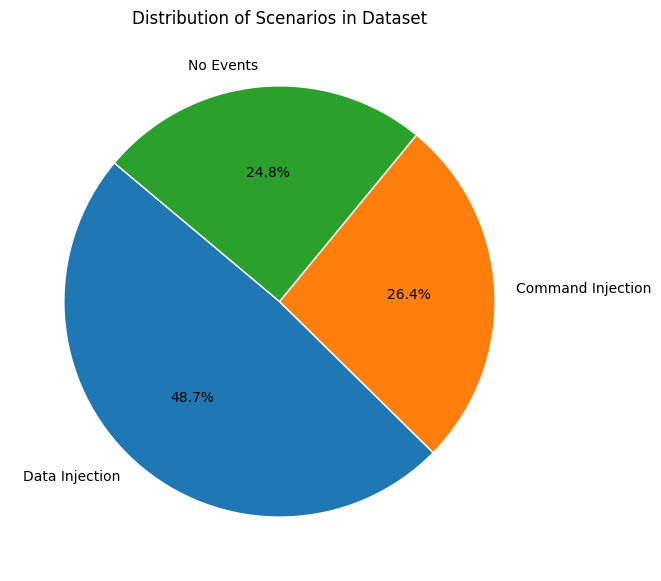

In [24]:
# Scenario → Group mapping
scenario_groups = {
    # "Natural Events": [1, 2, 3, 4, 5, 6, 13, 14],
    "No Events": [41],
    "Data Injection": [7, 8, 9, 10, 11, 12],
    "Command Injection": [15, 16, 17, 18],
    # "Relay Setting Change": [
    #     21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
    #     35, 36, 37, 38, 39, 40
    # ],
}

# Reverse lookup dictionary
scenario_to_group = {s: group for group, scenarios in scenario_groups.items() for s in scenarios}

# Distribution of instances per group
distribution = df["marker"].map(scenario_to_group).value_counts()

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    distribution.values,
    labels=distribution.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={"edgecolor": "white"}
)
plt.title("Distribution of Scenarios in Dataset")
plt.show()

In [25]:
# Split data into features and labels
X = df.drop(columns=['marker'])
y = df['marker']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [26]:
# Scale features using RobustScaler
scaler = RobustScaler()

# Fit on train and transform both in one step
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

# Transform test set
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# Create a LabelEncoder instance to encode target labels
le = LabelEncoder()

# Fit encoder on y_train and transform labels to numeric
y_train = le.fit_transform(y_train)  # Fit encoder on y_train and transform labels to numeric

# Transform y_test labels using the fitted encoder
y_test = le.transform(y_test)


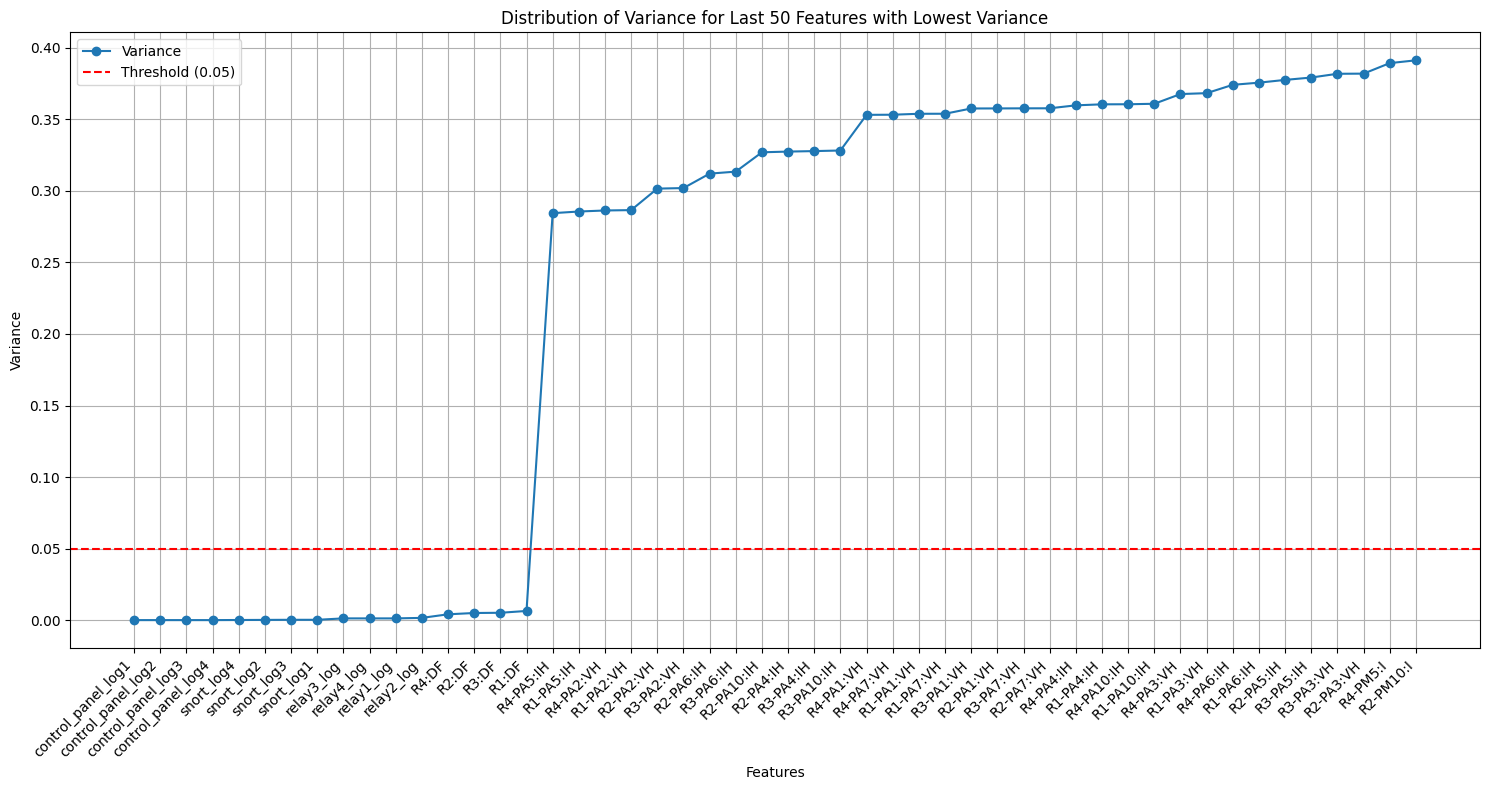

In [27]:
# Compute variances for all numeric columns
variances = X_train_scaled.var(numeric_only=True)

# Sort variances in descending order and select the last 50
last_50_variances = variances.sort_values(ascending=True).head(50)

# Plot the distribution as a line chart with a threshold line at 0.05
plt.figure(figsize=(15, 8))
plt.plot(range(len(last_50_variances)), last_50_variances.values, marker='o', label='Variance')
plt.axhline(y=0.05, color='r', linestyle='--', label='Threshold (0.05)')
plt.title('Distribution of Variance for Last 50 Features with Lowest Variance')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(range(len(last_50_variances)), last_50_variances.index, rotation=45, ha='right')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# Initialize the VarianceThreshold selector
selector = VarianceThreshold(threshold=0.05)

# Fit selector only on the training data
selector.fit(X_train_scaled)

# Transform both train and test sets using the fitted selector
X_train_selected = pd.DataFrame(selector.transform(X_train_scaled), 
                                columns=X_train_scaled.columns[selector.get_support()],
                                index=X_train_scaled.index)

X_test_selected = pd.DataFrame(selector.transform(X_test_scaled),
                               columns=X_test_scaled.columns[selector.get_support()],
                               index=X_test_scaled.index)

X_train.columns[selector.get_support()]

Index(['R1-PA1:VH', 'R1-PM1:V', 'R1-PA2:VH', 'R1-PM2:V', 'R1-PA3:VH',
       'R1-PM3:V', 'R1-PA4:IH', 'R1-PM4:I', 'R1-PA5:IH', 'R1-PM5:I',
       ...
       'R4-PA10:IH', 'R4-PM10:I', 'R4-PA11:IH', 'R4-PM11:I', 'R4-PA12:IH',
       'R4-PM12:I', 'R4:F', 'R4-PA:Z', 'R4-PA:ZH', 'R4:S'],
      dtype='object', length=112)

In [29]:
# Initialize models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'SVM': SVC(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=200, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

# Dictionary to store performance metrics for each model
performance_metrics = {}

# Train models and calculate metrics
for name, model in models.items():
    model.fit(X_train_selected, y_train)                  # Train model
    y_pred = model.predict(X_test_selected)               # Predict test labels
    
    # Compute metrics; average='weighted' for multiclass support and imbalance handling
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Store metrics in dictionary
    performance_metrics[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

pd.DataFrame.from_dict(performance_metrics, orient='index')

/home/maede/anaconda3/envs/ids/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:41:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/maede/anaconda3/envs/ids/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Accuracy,Precision,Recall,F1 Score
RandomForest,0.898759,0.898556,0.898759,0.898485
XGBoost,0.901015,0.900784,0.901015,0.900707
SVM,0.253525,0.183172,0.253525,0.109210
LogisticRegression,0.166667,0.210054,0.166667,0.154060
DecisionTree,0.811901,0.812702,0.811901,0.812068
KNN,0.543429,0.546882,0.543429,0.540711


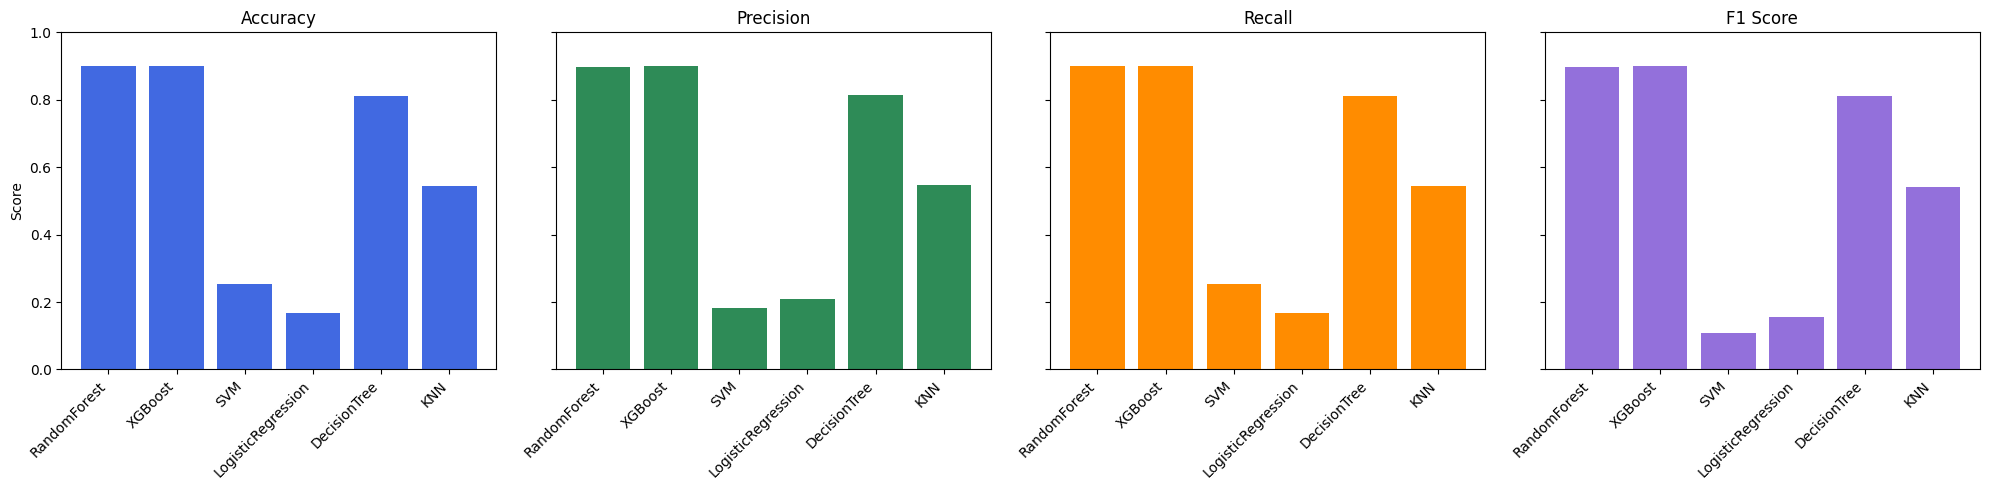

In [30]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x_pos = np.arange(len(performance_metrics.keys()))
colors = ['royalblue', 'seagreen', 'darkorange', 'mediumpurple']

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for i, metric in enumerate(metrics):
    values = [performance_metrics[m][metric] for m in models]
    axes[i].bar(x_pos, values, color=colors[i])
    axes[i].set_title(metric)
    axes[i].set_xticks(x_pos)
    axes[i].set_xticklabels(models, rotation=45, ha='right')
    axes[i].set_ylim(0, 1)
    if i == 0:
        axes[i].set_ylabel('Score')

plt.tight_layout()
plt.show()


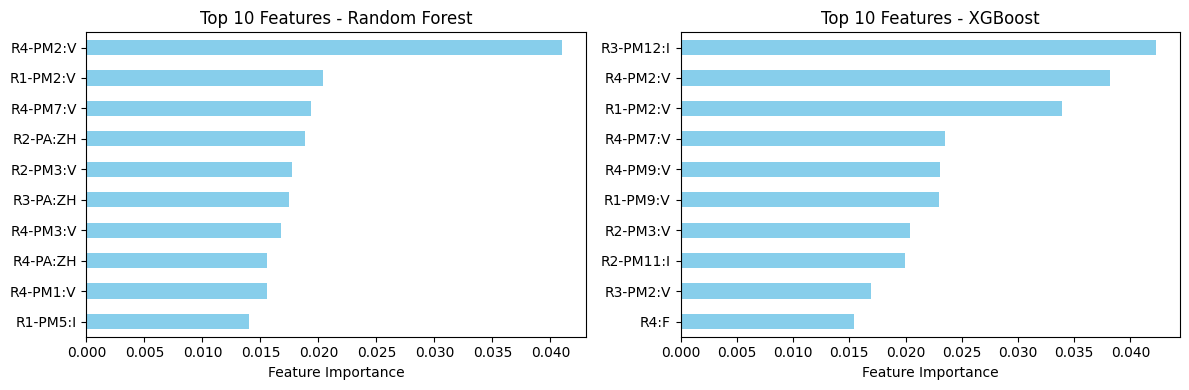

In [31]:
def plot_top_features(models, feature_names, top_n=10, ncols=2):
    n_models = len(models)
    nrows = -(-n_models // ncols)  # ceiling division

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
    axes = axes.flatten() if n_models > 1 else [axes]

    for ax, (name, model) in zip(axes, models.items()):
        importance_df = (
            pd.Series(model.feature_importances_, index=feature_names)
              .nlargest(top_n)
              .sort_values()
        )
        importance_df.plot(kind="barh", ax=ax, color="skyblue")
        ax.set_title(f"Top {top_n} Features - {name}")
        ax.set_xlabel("Feature Importance")

    # Hide unused axes if models < nrows*ncols
    for ax in axes[len(models):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()


# Example usage
feature_names = (
    X_train_selected.columns if hasattr(X_train, "columns")
    else [f"Feature {i}" for i in range(X_train.shape[1])]
)

plot_top_features(
    {"Random Forest": models["RandomForest"], "XGBoost": models["XGBoost"]},
    feature_names,
    top_n=10,
    ncols=2
)
